# Demonstration Machine Learning Model

This notebook outlines a simple machine-learning process using [Polars](https://pola.rs/) as the dataframe tool, and [scikit-learn](https://scikit-learn.org/stable/index.html) for modelling. The (fake) data records ice-cream sales versus mean daily temperatures. The model is intended to be able to predict ice-cream sales based on daily temperatures.

The following tasks will be executed:
1. Read initial data from S3
2. Separate the data into training and tests sets
3. Train a linear regression model, verifying that its R^{2} is adequate
4. Test the remaining data against the predictions of the model
5. If adequate, save the model to S3

Then, we will assume the model is being used at a later date to analyse new data (which does not conform to the previous data).
1. Load the serialised model from S3
2. Read the new data from S3
3. Compare it with the predictions of the loaded model and demonstrate that it is a poor fit
4. Create new training and test data sets
5. Retrain and test the model
6. Save the new parameters

First we install the Polars library on the instance...

In [ ]:
# %pip install polars # does not need to be run as Polars is installed

Then we import all the necessary dependencies. The other libraries are either part of Python or included on the instance by default.

In [1]:
import polars as pl
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pickle
import io
import boto3
import re
import os
from enum import Enum
from sklearn.base import BaseEstimator

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import sys
notebook_dir = os.getcwd()

project_root = os.path.dirname(notebook_dir)

sys.path.insert(0, project_root)

from utilities.version import ModelVersionManager

Specify the bucket and the source path of the initial data.

In [3]:
BUCKET = 'sfc-mt-sagemaker-demo'
DATA1 = f's3://{BUCKET}/data1/'

(Setting up boto3 client and deleting any previous run parameters.)

In [4]:
s3 = boto3.client('s3')
try:
    s3.delete_object(Bucket='sfc-mt-sagemaker-demo', Key='params/v1/params.pkl')
    print("Deleted params/v1/params.pkl from sfc-mt-sagemaker-demo")
    s3.delete_object(Bucket='sfc-mt-sagemaker-demo', Key='params/v2/params.pkl')
    print("Deleted params/v2/params.pkl from sfc-mt-sagemaker-demo")
except Exception as e:
    print(e)
    print('Deletion failed, possibly no files')

Deleted params/v1/params.pkl from sfc-mt-sagemaker-demo
Deleted params/v2/params.pkl from sfc-mt-sagemaker-demo


## Read the initial data from S3

In [5]:
df1 = pl.read_parquet(DATA1)
df1.head()

MeanDailyTemperature,IceCreamSales
f64,i64
14.5,4914290
21.3,5779564
22.2,5096651
12.3,2188966
14.1,3181548


In [20]:
df1.schema

Schema([('MeanDailyTemperature', Float64), ('IceCreamSales', Int64)])

In [21]:
from utilities.schema_reader import GlueSchemaReader
gsr = GlueSchemaReader("main-data-engineering-database")

In [19]:
plschema = gsr.get_polars_schema("dataset_ind_cqc_estimated_missing_ascwds_filled_posts")

## Separate into training and test sets

In [8]:
TRAIN_FRAC = 0.7
df_train1 = df1.sample(fraction=TRAIN_FRAC, with_replacement=False, shuffle=True, seed=55)
df_test1 = df1.join(df_train1, on=df1.columns, how='anti')

## Training
1. Put the data into numpy arrays for use by scikit-learn
2. Create and fit the model
3. Get the predicted values from the model

In [9]:
x1 = df_train1['MeanDailyTemperature'].to_numpy().reshape(-1,1)
y1 = df_train1['IceCreamSales'].to_numpy()
model1 = LinearRegression()
model1.fit(x1, y1)
y_pred1 = model1.predict(x1)

### Plot the training set and regression line

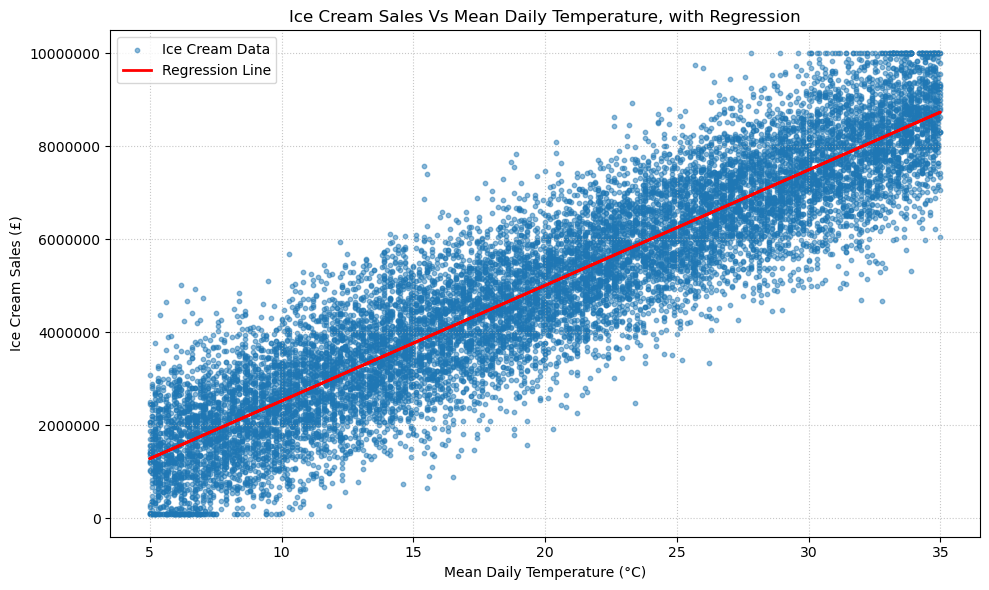

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x1, y1, alpha=0.5, s=10, label='Ice Cream Data')
ax.plot(x1, y_pred1, color='red', linewidth=2, label='Regression Line')
ax.set_title('Ice Cream Sales Vs Mean Daily Temperature, with Regression')
ax.set_xlabel('Mean Daily Temperature (°C)')
ax.set_ylabel('Ice Cream Sales (£)')
ax.ticklabel_format(style='plain', axis='y')
ax.grid(True, linestyle=':', alpha=0.7)
ax.legend()
plt.tight_layout()
plt.show()

Visually, this looks like a very good fit, but we should measure the fit numerically.

### Verify that the R^{2} is good

In [11]:
r2_1 = r2_score(y1, y_pred1)

print(f'The model has an R2 score {r2_1}')


The model has an R2 score 0.8356109000124763


This is a high value so we are happy that the fit is good.

## Check model against test set

In [12]:
x_test1 = df_test1['MeanDailyTemperature'].to_numpy().reshape(-1,1)
y_test1 = df_test1['IceCreamSales'].to_numpy()
y_test_pred1 = model1.predict(x_test1)
r2_test1 = r2_score(y_test1, y_test_pred1)
print(f'The model scores {r2_test1} on test data')

The model scores 0.831185745140915 on test data


Again, this is a high value, so we are happy that the model is robust.

Now we can extract the model parameters if desired.

In [13]:
slope = model1.coef_[0]
intercept = model1.intercept_
print(f'The model slope is {slope}, and the intercept is {intercept}')

The model slope is 248435.68598531868, and the intercept is 41570.931964274496


## Save the model to S3

We will serialise the model using the built-in [pickle](https://docs.python.org/3/library/pickle.html) module. For a simple linear model, it is possible just to save the model parameters in plain text, but it is better practice to save the full model instance for re-use.

In [16]:
param_store_name = 'models/test/v2/ice_cream'
vm = ModelVersionManager(BUCKET, 'params/v2', param_store_name)
vm.prompt_and_save(model1)

Do you want to save this new model version? (only yes to save):  yes
Is this a 
1. Major?
2. Minor?
3. Patch change?
(1/2/3):  1


Boto3 Error while retrieving parameter: An error occurred (AccessDeniedException) when calling the GetParameter operation: User: arn:aws:sts::344210435447:assumed-role/dev-sagemaker-execution-role/SageMaker is not authorized to perform: ssm:GetParameter on resource: arn:aws:ssm:eu-west-2:344210435447:* because no identity-based policy allows the ssm:GetParameter action


AccessDeniedException: An error occurred (AccessDeniedException) when calling the GetParameter operation: User: arn:aws:sts::344210435447:assumed-role/dev-sagemaker-execution-role/SageMaker is not authorized to perform: ssm:GetParameter on resource: arn:aws:ssm:eu-west-2:344210435447:* because no identity-based policy allows the ssm:GetParameter action

In [ ]:
# buffer = io.BytesIO()
# pickle.dump(model1, buffer)
# buffer.seek(0)

# s3.upload_fileobj(buffer, BUCKET, 'params/v1/params.pkl')

## New data

Now we imagine that some time has passed and new data is available. First the analyst reads in the model that has been saved to S3. Then s/he reads in the new data and compares it to the model predictions. If these turn out to be a poor fit, the training/testing/serialisation cycle is restarted.

## Retrieve the serialised model

In [ ]:
download = io.BytesIO()
s3.download_fileobj(BUCKET, 'params/v1/params.pkl', download)
download.seek(0)
loaded_model = pickle.load(download)
loaded_model.coef_[0], loaded_model.intercept_

## Retrieve the latest data

In [ ]:
DATA2 = f's3://{BUCKET}/data2/'
df2 = pl.read_parquet(DATA2)

## Compare the model predictions to the new data

In [ ]:
x2 = df2['MeanDailyTemperature'].to_numpy().reshape(-1,1)
y2 = df2['IceCreamSales'].to_numpy()
y_pred2 = loaded_model.predict(x2)
r2_loaded = r2_score(y2, y_pred2)
print(f'The R2 of the new data is {r2_loaded}')

This is a much lower score, indication that the model is not doing as good a job as it was previously. We can see this if we plot the data and regression line...

In [ ]:
fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.scatter(x2, y2, alpha=0.5, s=10, label='Ice Cream Data')
ax2.plot(x2, y_pred2, color='red', linewidth=2, label='Regression Line')
ax2.set_title('Ice Cream Sales Vs Mean Daily Temperature, with Regression')
ax2.set_xlabel('Mean Daily Temperature (°C)')
ax2.set_ylabel('Ice Cream Sales (£)')
ax2.ticklabel_format(style='plain', axis='y')
ax2.grid(True, linestyle=':', alpha=0.7)
ax2.legend()
plt.tight_layout()
plt.show()

## Repeat Training, Testing and Serialisation

### Separate the training and test sets

In [ ]:
df_train2 = df2.sample(fraction=TRAIN_FRAC, with_replacement=False, shuffle=True, seed=55)
df_test2 = df2.join(df_train2, on=df2.columns, how='anti')

### Train

In this case, we will simply train the model on the new data set. Alternatively, we could train it n the new data and previous data combined.

In [ ]:
x2 = df_train2['MeanDailyTemperature'].to_numpy().reshape(-1,1)
y2 = df_train2['IceCreamSales'].to_numpy()
model2 = LinearRegression()
model2.fit(x2, y2)
y_pred2 = model2.predict(x2)
r2_2 = r2_score(y2, y_pred2)

print(f'The new model has an R2 score {r2_2}')

This is much better and we can see the effect using another plot.

In [ ]:
fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.scatter(x2, y2, alpha=0.5, s=10, label='Ice Cream Data')
ax2.plot(x2, y_pred2, color='red', linewidth=2, label='Regression Line')
ax2.set_title('Ice Cream Sales Vs Mean Daily Temperature, with Regression')
ax2.set_xlabel('Mean Daily Temperature (°C)')
ax2.set_ylabel('Ice Cream Sales (£)')
ax2.ticklabel_format(style='plain', axis='y')
ax2.grid(True, linestyle=':', alpha=0.7)
ax2.legend()
plt.tight_layout()
plt.show()

### Test

In [ ]:
x_test2 = df_test2['MeanDailyTemperature'].to_numpy().reshape(-1,1)
y_test2 = df_test2['IceCreamSales'].to_numpy()
y_test_pred2 = model2.predict(x_test2)
r2_test2 = r2_score(y_test2, y_test_pred2)
print(f'The new model scores {r2_test2} on test data')

In [ ]:
slope = model2.coef_[0]
intercept = model2.intercept_
print(f'The new model slope is {slope}, and the intercept is {intercept}')

### Serialise

In [ ]:
buffer = io.BytesIO()
pickle.dump(model2, buffer)
buffer.seek(0)

s3.upload_fileobj(buffer, BUCKET, 'params/v2/params.pkl')

In [ ]:
class ChangeType(Enum):
    MAJOR = 1
    MINOR = 2
    PATCH = 3

class ModelVersionManager:
    """
    Manages semantic versioning for machine learning models using AWS Systems Manager
    Parameter Store.

    Attributes:
        param_store_name (str): The name of the parameter in Parameter Store.
        s3_bucket (str): The S3 bucket where models are stored.
        s3_prefix (str): The base prefix for model files in S3.
        ssm_client: The Boto3 client for Systems Manager.
    """

    def __init__(self, param_store_name, s3_bucket, s3_prefix):
        """
        Initializes the ModelVersionManager.

        Args:
            param_store_name (str): The name of the parameter in Parameter Store.
            s3_bucket (str): The S3 bucket where models are stored.
            s3_prefix (str): The base prefix for model files in S3.
        """
        self.param_store_name = param_store_name
        self.s3_bucket = s3_bucket
        self.s3_prefix = s3_prefix
        self.ssm_client = boto3.client('ssm')
        self.s3_client = boto3.client('s3')

    def _get_current_version(self):
        """
        Retrieves the current model version from Parameter Store.

        Returns:
            str: The current version string (e.g., "1.2.3").

        Raises:
            ClientError: If there is an error while connecting to the AWS API
        """
        try:
            response = self.ssm_client.get_parameter(Name=self.param_store_name, WithDecryption=False)
            return response['Parameter']['Value']
        except self.ssm_client.exceptions.ParameterNotFound:
            print(f"Parameter '{self.param_store_name}' not found. Initializing to 0.1.0.")
            return "0.1.0"
        except ClientError as e:
            print(f"Boto3 Error while retrieving parameter: {e}")
            raise e


    def _update_parameter_store(self, new_version: str) -> None:
        """
        Updates the version number in Parameter Store.

        Args:
            new_version (str): The new version string.
        """
        try:
            self.ssm_client.put_parameter(
                Name=self.param_store_name,
                Value=new_version,
                Type='String',
                Overwrite=True
            )
            print(f"Successfully updated Parameter Store with new version: {new_version}")
        except Exception as e:
            print(f"Error updating Parameter Store: {e}")
            raise e

    def _increment_version(self, current_version: str, change_type: ChangeType) -> str:
        """
        Increments the version number based on the change type.

        Args:
            current_version (str): The current version string.
            change_type (str): 'major', 'minor', or 'patch'.

        Returns:
            str: The new version string.

        Raises:
            ValueError: If the change type is invalid.
        """
        parts = [int(p) for p in current_version.split('.')]
        if change_type == '1':
            parts[0] += 1
            parts[1] = 0
            parts[2] = 0
        elif change_type == '2':
            parts[1] += 1
            parts[2] = 0
        elif change_type == '3':
            parts[2] += 1
        else:
            raise ValueError("Invalid change type. Must be  '1'(major), 'minor', or 'patch'.")

        return ".".join(map(str, parts))

    def get_new_version(self, change_type: ChangeType) -> str:
        """
        Calculates and returns the new version number.

        Args:
            change_type (ChangeType): 'MAJOR', 'MINOR', or 'PATCH'.

        Returns:
            str: The new version string.
        """
        try:
            current_version = self._get_current_version()
            new_version = self._increment_version(current_version, change_type)
            return new_version
        except ValueError as e:
            print(f"Error getting new version: {e}")


    def save_model(self, model: BaseEstimator, new_version: str):
        """
        Saves the trained model to S3 with the version number in the path.

        Args:
            model(BaseEstimator): The trained model object to be saved.
            new_version (str): The new version string.
        """
        prefix = f"{self.s3_prefix}/{new_version}/model.pkl"
        buffer = io.BytesIO()
        pickle.dump(model, buffer)
        buffer.seek(0)

        self.s3_client.upload_fileobj(buffer, self.s3_bucket, prefix)

        print(f"Saving model to s3://{self.s3_bucket}/{prefix}")

    def _prompt_change(self) -> ChangeType | None:
        selection = input("Is this a \n1. Major?\n2. Minor?\n3. Patch change?\n(1/2/3): ").lower()
        if selection not in ['1', '2', '3']:
            print("Invalid change type. Model not saved.")
            return None
        match selection:
            case '1':
                return ChangeType.MAJOR
            case '2':
                return ChangeType.MINOR
            case '3':
                return ChangeType.PATCH
            case _:
                return None

    def prompt_and_save(self, model):
        """
        Prompts the user for a change type and handles the versioning and saving process.

        Args:
            model: The trained model object.
        """
        should_save = input("Do you want to save this new model version? (only yes to save): ").lower()
        if should_save != 'yes':
            print("Model not saved. Exiting.")
            return

        change_type = self._prompt_change()

        new_version = self.get_new_version(change_type)
        self.save_model(model, new_version)
        self._update_parameter_store(new_version)

In [ ]:
NEW_BUCKET = 'spike-polars-data'
PREFIX = 'testing/123'

mvm = ModelVersionManager(